In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv("predictive_maintenance.csv")

# Drop unnecessary columns
df.drop(columns=["UDI", "Product ID"], inplace=True)

# Encode categorical variables
label_enc = LabelEncoder()
df["Type"] = label_enc.fit_transform(df["Type"])
df["Failure Type"] = label_enc.fit_transform(df["Failure Type"])

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Save processed data
df.to_csv("processed_data.csv", index=False)


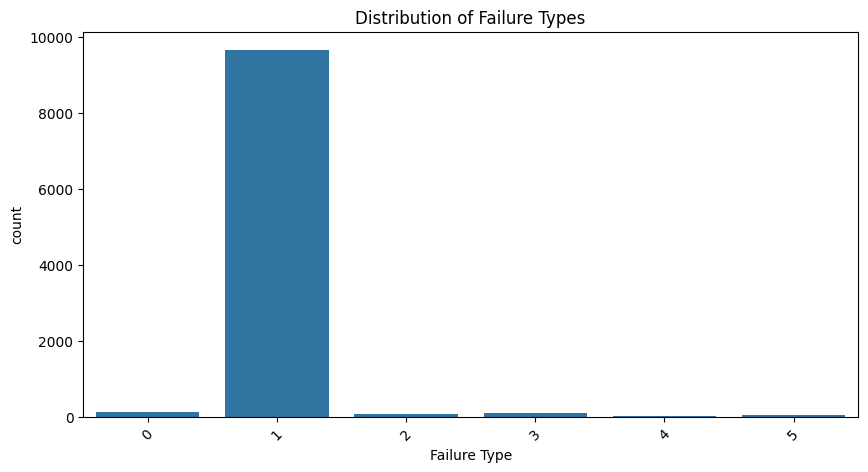

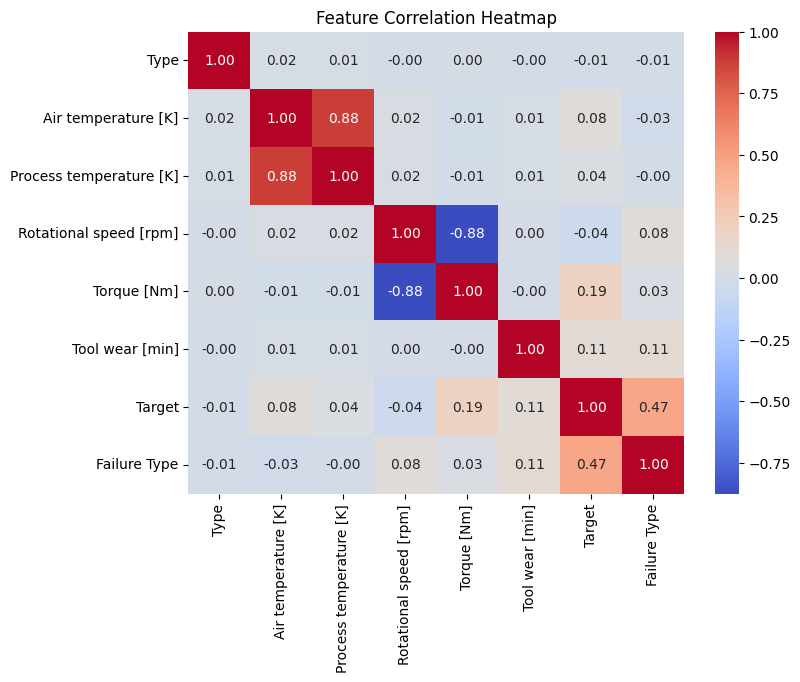

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=df["Failure Type"])
plt.title("Distribution of Failure Types")
plt.xticks(rotation=45)
plt.show()

# Correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



In [3]:
from imblearn.over_sampling import SMOTE

X = df.drop(columns=["Failure Type"])
y = df["Failure Type"]

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=["Failure Type"])], axis=1)
df_resampled.to_csv("balanced_data.csv", index=False)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to tensors and move to device
X_tensor = torch.tensor(X_resampled.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_resampled.values, dtype=torch.long).to(device)

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define Neural Network
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(X_tensor.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, len(y_resampled.unique()))
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model and move it to device
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure data is on the correct device

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Using device: cuda
Epoch 1/50, Loss: 0.0690
Epoch 2/50, Loss: 0.1097
Epoch 3/50, Loss: 0.0189
Epoch 4/50, Loss: 0.0071
Epoch 5/50, Loss: 0.0112
Epoch 6/50, Loss: 0.1200
Epoch 7/50, Loss: 0.0053
Epoch 8/50, Loss: 0.0408
Epoch 9/50, Loss: 0.3365
Epoch 10/50, Loss: 0.0072
Epoch 11/50, Loss: 0.0169
Epoch 12/50, Loss: 0.0026
Epoch 13/50, Loss: 0.0018
Epoch 14/50, Loss: 0.0021
Epoch 15/50, Loss: 0.0019
Epoch 16/50, Loss: 0.0158
Epoch 17/50, Loss: 0.0009
Epoch 18/50, Loss: 0.0544
Epoch 19/50, Loss: 0.0004
Epoch 20/50, Loss: 0.0023
Epoch 21/50, Loss: 0.0289
Epoch 22/50, Loss: 0.0053
Epoch 23/50, Loss: 0.0019
Epoch 24/50, Loss: 0.0226
Epoch 25/50, Loss: 0.0008
Epoch 26/50, Loss: 0.0013
Epoch 27/50, Loss: 0.0046
Epoch 28/50, Loss: 0.0028
Epoch 29/50, Loss: 0.0007
Epoch 30/50, Loss: 0.0166
Epoch 31/50, Loss: 0.0017
Epoch 32/50, Loss: 0.0037
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0001
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0038
Epoch 37/50, Loss: 0.0171
Epoch 38/50, Loss: 0.0241
Ep

In [5]:
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Wrap PyTorch model for GridSearch
model_skorch = NeuralNetClassifier(
    Classifier,
    max_epochs=50,
    lr=0.01,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=32,
    device=device
)

# Define hyperparameter grid
param_grid = {
    "lr": [0.001, 0.01, 0.1],
    "optimizer": [optim.Adam, optim.SGD],
    "batch_size": [16, 32, 64],
}

# Perform Grid Search
grid_search = GridSearchCV(model_skorch, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_resampled.values.astype("float32"), y_resampled.values.astype("int64"))

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Using device: cuda
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5268       0.2286        1.7291  6.4584
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5110       0.1883        4.6628  6.7064
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4679       0.1674        6.5360  7.1920
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5450       0.2164        1.6935  6.7303
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4320       0.1812        6.1796  6.9652
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1     

KeyboardInterrupt: 

In [ ]:
import torch
import matplotlib.pyplot as plt

# Ensure the model and data are moved to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop with logging
train_losses = []
train_acc = []

for epoch in range(num_epochs):
    correct = 0
    total = 0
    epoch_loss = 0
    
    for inputs, labels in train_loader:
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(epoch_loss / len(train_loader))
    train_acc.append(correct / total)

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on training data
y_pred_train = model(X_tensor).argmax(dim=1).numpy()
y_true_train = y_tensor.numpy()

# Classification report
print("Training Metrics:")
print(classification_report(y_true_train, y_pred_train))

# Predict on test set (if available)
# y_pred_test = model(X_test_tensor).argmax(dim=1).numpy()
# y_true_test = y_test_tensor.numpy()
# print("Test Metrics:")
# print(classification_report(y_true_test, y_pred_test))
